# **Group Members:**
# **Moosa Imran (20L-0917), Mustafa Nosher (20L-0925), Anas Ahmad (20L-0932)**

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=31f9f5c44129ccf6a3e3e9dbb92956d9ba0222d5214b6766a9a6ca16b768b0c6
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkConf

from pyspark.sql.functions import col, split, explode, trim, lower, collect_list, regexp_replace, array, concat, struct
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler, IndexToString
from pyspark.ml.linalg import SparseVector
from pyspark.ml.recommendation import ALS

from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
import numpy as np


spark = SparkSession.builder \
    .appName("Anime Recommendation System") \
    .getOrCreate()

In [ ]:
anime_df = spark.read.csv('anime.csv', header=True, inferSchema=True)
ratings_df = spark.read.csv('rating.csv', header=True, inferSchema=True)

anime_df.show()
ratings_df.show()

+--------+--------------------+--------------------+-----+--------+------+-------+
|anime_id|                name|               genre| type|episodes|rating|members|
+--------+--------------------+--------------------+-----+--------+------+-------+
|   32281|      Kimi no Na wa.|Drama, Romance, S...|Movie|       1|  9.37| 200630|
|    5114|Fullmetal Alchemi...|Action, Adventure...|   TV|      64|  9.26| 793665|
|   28977|            Gintama°|Action, Comedy, H...|   TV|      51|  9.25| 114262|
|    9253|         Steins;Gate|    Sci-Fi, Thriller|   TV|      24|  9.17| 673572|
|    9969|       Gintama&#039;|Action, Comedy, H...|   TV|      51|  9.16| 151266|
|   32935|Haikyuu!!: Karasu...|Comedy, Drama, Sc...|   TV|      10|  9.15|  93351|
|   11061|Hunter x Hunter (...|Action, Adventure...|   TV|     148|  9.13| 425855|
|     820|Ginga Eiyuu Densetsu|Drama, Military, ...|  OVA|     110|  9.11|  80679|
|   15335|Gintama Movie: Ka...|Action, Comedy, H...|Movie|       1|   9.1|  72534|
|   

# **Content Based Filtering**

In [ ]:
# casting anime_id in both csv files to integer
anime_df = anime_df.withColumn("anime_id", col("anime_id").cast(IntegerType()))
ratings_df = ratings_df.withColumn("anime_id", col("anime_id").cast(IntegerType()))

# removing rows with rating less than 0
ratings_df = ratings_df.filter(ratings_df["rating"] >= 0)

anime_df.show(5)

+--------+--------------------+--------------------+-----+--------+------+-------+
|anime_id|                name|               genre| type|episodes|rating|members|
+--------+--------------------+--------------------+-----+--------+------+-------+
|   32281|      Kimi no Na wa.|Drama, Romance, S...|Movie|       1|  9.37| 200630|
|    5114|Fullmetal Alchemi...|Action, Adventure...|   TV|      64|  9.26| 793665|
|   28977|            Gintama°|Action, Comedy, H...|   TV|      51|  9.25| 114262|
|    9253|         Steins;Gate|    Sci-Fi, Thriller|   TV|      24|  9.17| 673572|
|    9969|       Gintama&#039;|Action, Comedy, H...|   TV|      51|  9.16| 151266|
+--------+--------------------+--------------------+-----+--------+------+-------+
only showing top 5 rows



In [ ]:
# checking if genre is not null or empty string
anime_df = anime_df.filter(col("genre").isNotNull() & (col("genre") != ""))
anime_df = anime_df.withColumn("genre", col("genre").cast(StringType()))


# tokenizing on the base of anime title
tokenizer_title = Tokenizer(inputCol="name", outputCol="title_words")
anime_words_df = tokenizer_title.transform(anime_df)

# creating TF-IDF based vectors for titles to be used for cosine similarity later
hashingTF_title = HashingTF(inputCol="title_words", outputCol="title_rawFeatures", numFeatures=1000)
tf_df_title = hashingTF_title.transform(anime_words_df)

idf_title = IDF(inputCol="title_rawFeatures", outputCol="title_features")
tfidf_df_title = idf_title.fit(tf_df_title).transform(tf_df_title)
tfidf_df_title.show(5)

########################################################################################################################################################

# tokenizing on the base of anime genre
tokenizer_genre = Tokenizer(inputCol="genre", outputCol="genre_words")
genre_words_df = tokenizer_genre.transform(anime_df)

# removing extra comma at end of each index
genre_words_df = genre_words_df.withColumn(
    "genre_words",
    array(*[regexp_replace(col("genre_words")[i], ",", "").alias("genre_word") for i in range(len(genre_words_df.select("genre_words").first()[0]))])
)

# creating TF-IDF based vectors for genres to be used for cosine similarity later
hashingTF_genre = HashingTF(inputCol="genre_words", outputCol="genre_rawFeatures", numFeatures=1000)
tf_df_genre = hashingTF_genre.transform(genre_words_df)

idf_genre = IDF(inputCol="genre_rawFeatures", outputCol="genre_features")
tfidf_df_genre = idf_genre.fit(tf_df_genre).transform(tf_df_genre)
tfidf_df_genre.show(5)

+--------+--------------------+--------------------+-----+--------+------+-------+--------------------+--------------------+--------------------+
|anime_id|                name|               genre| type|episodes|rating|members|         title_words|   title_rawFeatures|      title_features|
+--------+--------------------+--------------------+-----+--------+------+-------+--------------------+--------------------+--------------------+
|   32281|      Kimi no Na wa.|Drama, Romance, S...|Movie|       1|  9.37| 200630| [kimi, no, na, wa.]|(1000,[304,704,82...|(1000,[304,704,82...|
|    5114|Fullmetal Alchemi...|Action, Adventure...|   TV|      64|  9.26| 793665|[fullmetal, alche...|(1000,[85,113,885...|(1000,[85,113,885...|
|   28977|            Gintama°|Action, Comedy, H...|   TV|      51|  9.25| 114262|          [gintama°]|  (1000,[921],[1.0])|(1000,[921],[5.91...|
|    9253|         Steins;Gate|    Sci-Fi, Thriller|   TV|      24|  9.17| 673572|       [steins;gate]|  (1000,[664],[1.0])|

In [ ]:
# combining TF-IDF features for title and genre into a single column
tfidf_df_combined = tfidf_df_title.join(
    tfidf_df_genre.select("anime_id", "genre_words", "genre_rawFeatures", "genre_features"),
    on="anime_id",
    how="inner"
)

tfidf_df_combined.show(5, truncate=False)

+--------+--------------------------------+------------------------------------------------------------+-----+--------+------+-------+------------------------------------+------------------------------------------+--------------------------------------------------------------------------------------------------+--------------------------------------+------------------------------------------+-----------------------------------------------------------------------------------------------------+
|anime_id|name                            |genre                                                       |type |episodes|rating|members|title_words                         |title_rawFeatures                         |title_features                                                                                    |genre_words                           |genre_rawFeatures                         |genre_features                                                                                       |
+---

In [ ]:
def cosine_similarity(v1, v2):
    dot_product = float(v1.dot(v2))
    norm1 = np.linalg.norm(v1.toArray())
    norm2 = np.linalg.norm(v2.toArray())
    if norm1 == 0 or norm2 == 0:
        return 0
    return dot_product / (norm1 * norm2)

In [ ]:
def recommend_anime(user_id, ratings_df, anime_df, tfidf_df_combined, top_n=5):
    # IDs of all animes rated by user
    user_ratings = ratings_df.filter(col("user_id") == user_id).select("anime_id", "rating").collect()

    if not user_ratings:
        return []

    # extracting only N top rated animes
    if len(user_ratings) > 10:
      user_ratings = sorted(user_ratings, key=lambda x: x["rating"], reverse=True)[:10]

    rated_anime_ids = [rating["anime_id"] for rating in user_ratings]

    ######################################################################################################################################
    # TF-IDF vectors for the user's rated anime genre features
    user_anime_vectors = tfidf_df_combined.filter(col("anime_id").isin(rated_anime_ids)).select("genre_features").collect()

    # calculating cosine similarity
    similar_genres = []
    for row in tfidf_df_combined.collect():
        anime_id = row["anime_id"]
        if anime_id in rated_anime_ids:
            continue

        max_similarity = 0
        for user_vector in user_anime_vectors:
            similarity = cosine_similarity(
                user_vector["genre_features"],
                row["genre_features"]
            )
            max_similarity = max(max_similarity, similarity)

        similar_genres.append((anime_id, max_similarity))

    # sorting and return the top N recommended anime based on genre
    similar_genres_sorted = sorted(similar_genres, key=lambda x: x[1], reverse=True)[:top_n]

    # names of recommended anime based on genre
    recommended_anime_genres = [
        anime_df.filter(col("anime_id") == rec[0]).select("name").collect()[0]["name"]
        for rec in similar_genres_sorted
    ]
    ######################################################################################################################################
    # list of animes already recommended based on genre so that we can make sure they are not recommended again
    already_recommended_anime_ids = [item[0] for item in similar_genres_sorted]

    # TF-IDF vectors for the user's rated anime title features
    user_anime_vectors = tfidf_df_combined.filter(col("anime_id").isin(rated_anime_ids)).select("title_features").collect()

    # calculating cosine similarity
    similar_titles = []
    for row in tfidf_df_combined.collect():
        anime_id = row["anime_id"]
        if (anime_id in rated_anime_ids) or (anime_id in already_recommended_anime_ids):
            continue

        max_similarity = 0
        for user_vector in user_anime_vectors:
            similarity = cosine_similarity(
                user_vector["title_features"],
                row["title_features"]
            )
            max_similarity = max(max_similarity, similarity)

        similar_titles.append((anime_id, max_similarity))

    # sorting and return the top N recommended anime based on title
    similar_titles_sorted = sorted(similar_titles, key=lambda x: x[1], reverse=True)[:top_n]

    # names of recommended anime based on title
    recommended_anime_titles = [
        anime_df.filter(col("anime_id") == rec[0]).select("name").collect()[0]["name"]
        for rec in similar_titles_sorted
    ]
    ######################################################################################################################################
    recommended_anime =  recommended_anime_genres + recommended_anime_titles

    return recommended_anime

In [ ]:
user_id = 2
recommended_anime = recommend_anime(user_id, ratings_df, anime_df, tfidf_df_combined, top_n=5)

print("Recommended Anime: \n")
for anime in recommended_anime:
    print(anime)

Recommended Anime: 

Kuroko no Basket 3rd Season
Kuroko no Basket 2nd Season
Diamond no Ace: Second Season
Diamond no Ace
Prince of Tennis: The National Tournament Finals
Kuroko no Basket NG-shuu
Kuroko no Basket 2nd Season NG-shuu
Baccano!
Kuroko no Basket 3rd Season NG-shuu
Toilet no Hanako-san


Titles that "user_id = 334" has rated in the dataset

Naruto,
Bokusatsu Tenshi Dokuro-chan,
Death Note,
Code Geass: Hangyaku no Lelouch,
Bokusatsu Tenshi Dokuro-chan 2,
Code Geass: Hangyaku no Lelouch R2,
Bakemonogatari,
Kiss x Sis (TV),
Steins;Gate,
JoJo no Kimyou na Bouken (TV)

# **Collaborative Filtering**

In [ ]:
anime_df = spark.read.csv('anime.csv', header=True, inferSchema=True)
ratings_df = spark.read.csv('rating.csv', header=True, inferSchema=True)

# removing rating from anime_dataset since we are only considering user_rating
anime_data = anime_df.drop('rating')

# merge data on the anime_id column
data = anime_data.join(ratings_df, on='anime_id', how='inner')
data.show(10)

+--------+--------------------+--------------------+-----+--------+-------+-------+------+
|anime_id|                name|               genre| type|episodes|members|user_id|rating|
+--------+--------------------+--------------------+-----+--------+-------+-------+------+
|      20|              Naruto|Action, Comedy, M...|   TV|     220| 683297|      1|    -1|
|      24|       School Rumble|Comedy, Romance, ...|   TV|      26| 178553|      1|    -1|
|      79|            Shuffle!|Comedy, Drama, Ec...|   TV|      24| 158772|      1|    -1|
|     226|          Elfen Lied|Action, Drama, Ho...|   TV|      13| 623511|      1|    -1|
|     241|Girls Bravo: Firs...|Comedy, Ecchi, Fa...|   TV|      11|  84395|      1|    -1|
|     355|   Shakugan no Shana|Action, Drama, Fa...|   TV|      24| 297058|      1|    -1|
|     356|     Fate/stay night|Action, Fantasy, ...|   TV|      24| 374880|      1|    -1|
|     442|Naruto Movie 1: D...|Adventure, Comedy...|Movie|       1| 120571|      1|    -1|

In [ ]:
# filter dataset for recommender system
data = data.selectExpr('user_id','name','rating') # here rating is the rating given by user
# converting the rating and user_id to integer so that we can perform ALS on it
data = data.withColumn('rating',data['rating'].cast('int')).withColumn('user_id',data['user_id'].cast('int'))

data.show(10)

# StringIndexer assigns unique numerical value to each name
indexer = StringIndexer(inputCol="name", outputCol="name_idx")
indexer = indexer.fit(data)
data_transformed = indexer.transform(data)

data_transformed.show(10)

+-------+--------------------+------+
|user_id|                name|rating|
+-------+--------------------+------+
|      1|              Naruto|    -1|
|      1|       School Rumble|    -1|
|      1|            Shuffle!|    -1|
|      1|          Elfen Lied|    -1|
|      1|Girls Bravo: Firs...|    -1|
|      1|   Shakugan no Shana|    -1|
|      1|     Fate/stay night|    -1|
|      1|Naruto Movie 1: D...|    -1|
|      1|Girls Bravo: Seco...|    -1|
|      1|School Rumble Ni ...|    -1|
+-------+--------------------+------+
only showing top 10 rows

+-------+--------------------+------+--------+
|user_id|                name|rating|name_idx|
+-------+--------------------+------+--------+
|      1|              Naruto|    -1|     6.0|
|      1|       School Rumble|    -1|   214.0|
|      1|            Shuffle!|    -1|   216.0|
|      1|          Elfen Lied|    -1|     4.0|
|      1|Girls Bravo: Firs...|    -1|   488.0|
|      1|   Shakugan no Shana|    -1|    76.0|
|      1|     Fate/

In [ ]:
data_transformed.columns

['user_id', 'name', 'rating', 'name_idx']

In [ ]:
# dataset split into training and testing set
(training_data, test_data) = data_transformed.randomSplit([0.75, 0.25])

# training the model
als_model = ALS(implicitPrefs=False,ratingCol='rating',userCol="user_id", itemCol="name_idx",maxIter=10)
model = als_model.fit(training_data)

In [ ]:
# predictions
from pyspark.ml.evaluation import RegressionEvaluator

predictions = model.transform(test_data)
predictions = predictions.na.drop(subset=["prediction"])

# evaluating the model by computing the RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print(f"Root Mean Square Error (RMSE): {rmse}")

Root Mean Square Error (RMSE): 2.0443922191959305


In [ ]:
labels = indexer.labels

idx_to_name={x:y for x,y in enumerate(list(labels))}

In [ ]:
user_id =  3

output = model.recommendForAllUsers(5).filter(col('user_id')==user_id).select("recommendations").collect()
print(output)
anime = []
for item in output[0][0]:
  anime.append(idx_to_name[item.name_idx])

[Row(recommendations=[Row(name_idx=8182, rating=11.471681594848633), Row(name_idx=7499, rating=10.68071174621582), Row(name_idx=7825, rating=10.583542823791504), Row(name_idx=7876, rating=10.28482723236084), Row(name_idx=8799, rating=10.154970169067383)])]


In [ ]:
print("Recommended Anime: \n")
for a in anime:
  print(a)

Recommended Anime: 

Esper Mami: Hoshizora no Dancing Doll
Ginga Tetsudou no Yoru: Fantasy Railroad in the Stars
Monkey Turn
Chogattai Majutsu Robot Ginguiser
Wansa-kun


# **User Segmentation and Anime Analysis Using Kmeans**


In [ ]:
# reading and cleaning dataset
def read_data_set():
  anime_df = spark.read.csv('anime.csv', header=True, inferSchema=True)
  ratings_df = spark.read.csv('rating.csv', header=True, inferSchema=True)
  ratings_df=ratings_df.withColumnRenamed("rating", "userrating")
  return anime_df,ratings_df

def clean_data_set(anime_df,ratings_df):
  anime_df = anime_df.withColumn("anime_id", col("anime_id").cast(IntegerType()))
  ratings_df = ratings_df.withColumn("anime_id", col("anime_id").cast(IntegerType()))
  ratings_df = ratings_df.filter(ratings_df["userrating"] >= 0)
  anime_df = anime_df.withColumn("genre", split(col("genre"), ", "))
  anime_df = anime_df.fillna(0)
  ratings_df = ratings_df.fillna(0)
  return anime_df,ratings_df

**Perform kmean for Analysis**

In [ ]:
# combine both datasets on anime_id
def combine_dataset(anime_df,ratings_df):
  merged_df = anime_df.join(ratings_df, 'anime_id')
  merged_df.show(2)
  #convert the actual rating and user rating to double dataype
  merged_df = merged_df.withColumn('rating', merged_df['rating'].cast('double'))
  merged_df = merged_df.withColumn('userrating', merged_df['userrating'].cast('double'))
  # merged_df = merged_df.withColumn('members', merged_df['members'].cast('double'))
  return merged_df


# K-Means clustering for analysis using rating and user_rating
def kmean_clustering(merged_df):
  feature_cols = ['rating', 'userrating']
  assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
  feature_vector = assembler.transform(merged_df)
  feature_vector.show()
  scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
  scaled_data = scaler.fit(feature_vector).transform(feature_vector)
  kmeans = KMeans(k=3, seed=42)  # Assuming 3 clusters
  model = kmeans.fit(scaled_data)
  clustered_df = model.transform(scaled_data)
  cluster_centers = model.clusterCenters()
  return clustered_df,cluster_centers

In [ ]:
# check for best cluster based on WSSE
def check_for_best_cluster(clustered_df,cluster_centers):
  best_cluster = None
  best_cluster_score = float('inf')
  for i, center in enumerate(cluster_centers):
      # print(f"Cluster {i+1} Center: {center}")
      distances = clustered_df.rdd.map(lambda point: float(point.features.squared_distance(center)))
      within_cluster_sum_squared_distances = distances.reduce(lambda x, y: x + y)
      if within_cluster_sum_squared_distances < best_cluster_score:
        best_cluster = i + 1
        best_cluster_score = within_cluster_sum_squared_distances
  print(f"Best Cluster: {best_cluster}")
  return best_cluster

In [ ]:
# function to get most loved animes
def get_analysis(best_cluster,n):
  best_cluster_df = clustered_df.filter(clustered_df.prediction == best_cluster)
  avg_rating_df = best_cluster_df.groupBy('anime_id', 'name').agg(
      F.avg('rating').alias('avg_rating'),
      F.avg('userrating').alias('avg_user_rating')
  )
  avg_rating_df = avg_rating_df.withColumn('combined_score',
                                          (F.col('avg_rating') + F.col('avg_user_rating')) / 2)
  top_10_anime = avg_rating_df.orderBy('combined_score', ascending=False).limit(n)
  top_10_anime.select("anime_id","name").distinct().show()

In [ ]:
# perform customer segmentation using K-Means based on user_rating for each anime type
def customer_segmentation_by_anime_type(merged_df):
    merged_df = merged_df.dropna(subset=['type'])
    indexer = StringIndexer(inputCol="type", outputCol="type_index")
    encoder = OneHotEncoder(inputCol="type_index", outputCol="type_encoded")
    pipeline = Pipeline(stages=[indexer, encoder])
    pipeline_model = pipeline.fit(merged_df)
    transformed_df = pipeline_model.transform(merged_df)

    unique_types = transformed_df.select("type").distinct().rdd.map(lambda row: row[0]).collect()
    customer_data = transformed_df.select(['anime_id', 'userrating', 'type_encoded'])
    assembler = VectorAssembler(inputCols=['userrating', 'type_encoded'], outputCol='features')
    customer_features = assembler.transform(customer_data)
    scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=False)
    scaled_customer_data = scaler.fit(customer_features).transform(customer_features)
    kmeans = KMeans(k=5, seed=42)
    model = kmeans.fit(scaled_customer_data)
    predictions = model.transform(scaled_customer_data)

    return predictions, unique_types

In [ ]:
# visualize results for customer segmentation
def visualize_anime_type_clusters(predictions, unique_types):
    cluster_avg_rating = predictions.groupBy('prediction').agg(
        *[F.avg('userrating').alias('avg_rating_' + anime_type) for anime_type in unique_types]
    ).toPandas().set_index('prediction')

    cluster_avg_rating = cluster_avg_rating.sort_index()

    fig, ax = plt.subplots(figsize=(12, 6))
    cluster_avg_rating.plot(kind='bar', ax=ax)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Rating')
    ax.set_title('Average Rating of Anime Types Across Clusters')
    plt.xticks(rotation=0)
    plt.legend(title='Anime Type')
    plt.show()

In [ ]:
print("PERFORMING ANALYSIS TO GET THE MOST LOVED ANIMES SO FAR........")
anime_df,ratings_df=read_data_set()
anime_df,ratings_df=clean_data_set(anime_df,ratings_df)
merged_df= combine_dataset(anime_df,ratings_df)
clustered_df,cluster_centers=kmean_clustering(merged_df)
best_cluster=check_for_best_cluster(clustered_df,cluster_centers)

PERFORMING ANALYSIS TO GET THE MOST LOVED ANIMES SO FAR........
+--------+--------------------+--------------------+----+--------+------+-------+-------+----------+
|anime_id|                name|               genre|type|episodes|rating|members|user_id|userrating|
+--------+--------------------+--------------------+----+--------+------+-------+-------+----------+
|    8074|Highschool of the...|[Action, Ecchi, H...|  TV|      12|  7.46| 535892|      1|        10|
|   11617|     High School DxD|[Comedy, Demons, ...|  TV|      12|   7.7| 398660|      1|        10|
+--------+--------------------+--------------------+----+--------+------+-------+-------+----------+
only showing top 2 rows

+--------+--------------------+--------------------+-----+--------+------+-------+-------+----------+-----------+
|anime_id|                name|               genre| type|episodes|rating|members|user_id|userrating|   features|
+--------+--------------------+--------------------+-----+--------+------+---

In [ ]:
get_analysis(best_cluster,10)

+--------+--------------------+
|anime_id|                name|
+--------+--------------------+
|   32281|      Kimi no Na wa.|
|   28977|            Gintama°|
|    5114|Fullmetal Alchemi...|
|     820|Ginga Eiyuu Densetsu|
|    9969|       Gintama&#039;|
|    9253|         Steins;Gate|
|    4181|Clannad: After Story|
|   15335|Gintama Movie: Ka...|
|   11061|Hunter x Hunter (...|
|   15417|Gintama&#039;: En...|
+--------+--------------------+



PERFORMING USER SEGMENTATION.......
VISUALIZING USER SEGMENTATION.......


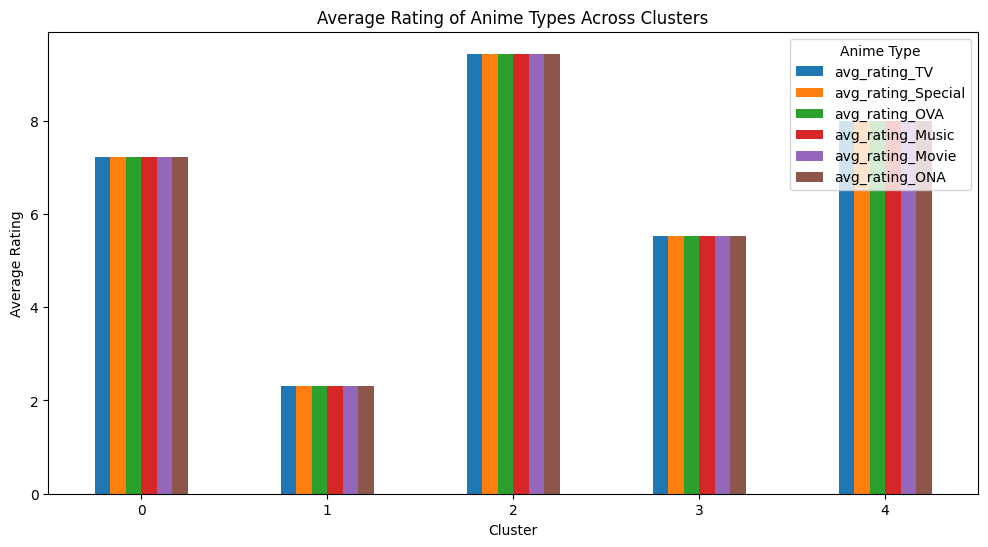

In [ ]:
print("PERFORMING USER SEGMENTATION.......")
predictions, unique_types=customer_segmentation_by_anime_type(merged_df)
print("VISUALIZING USER SEGMENTATION.......")
visualize_anime_type_clusters(predictions, unique_types)